# Variant Sequence Analysis

For each variant sequence:
1. Look at all human strains within {0, 1, 3, 6} months of collection date (0 is 1 day before collection date)
2. For each HA subtype (in the HA column) with $\geq 15$ sequences:
    1. Construct an Enet with those HA sequences, including the variant strain (capped at 10k sequences)
    2. For all unique sequences, find the minimum E-distance between that sequence and the variant sequence under the Enet
3. Repeat step 2 for NA
4. Take the minimum E-distance across all subtypes for both HA and NA
5. Predict IRAT Emergence scores with `emergenet.emergenet.predict_irat_emergence`
6. Save results: `results/variant_predictions/variant.csv`

    
### Running Processes

Computations are done in:
- `variant_predictions.py`
- `run_variant_predictions.sh`

To run, navigate to terminal and do

`chmod ugo+rwx run_variant_predictions.sh`

`./run_variant_predictions.sh`

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 300
import warnings
warnings.filterwarnings('ignore')
from emergenet.emergenet import predict_irat_emergence
from zedstat.textable import textable


RESULT_DIR = 'results/variant_predictions/'
OUT_DIR = 'tables/'

In [65]:
# Compile variant results
variant = pd.read_csv(RESULT_DIR+'/variant.csv')
ha_risks = {'0':[], '1':[], '3':[], '6':[]}
na_risks = {'0':[], '1':[], '3':[], '6':[]}
for i in range(len(variant)):
    row = variant.iloc[i]
    virus_name = row['name'].replace('/',':')
    for month in ha_risks:
        DIR = RESULT_DIR + virus_name + '/' + month + '/results/'
        try:
            ha_risk = pd.read_csv(DIR + 'HA_min_risks.csv').min(axis=1).values[0] + 1e-5
        except:
            ha_risk = -1
        try:
            na_risk = pd.read_csv(DIR + 'NA_min_risks.csv').min(axis=1).values[0] + 1e-5
        except:
            na_risk = -1
        ha_risks[month].append(ha_risk)
        na_risks[month].append(na_risk)
    
# Predict emergence risk
for month in ha_risks:
    variant[f'ha_risk_{month}'] = ha_risks[month]
    variant[f'na_risk_{month}'] = na_risks[month]
    variant[f'geom_mean_risk_{month}'] = np.sqrt(variant[f'ha_risk_{month}'] * variant[f'na_risk_{month}'])
    variant[[f'emergence_{month}', f'emergence_low_{month}', f'emergence_high_{month}']] = variant.apply(lambda row: predict_irat_emergence(row[f'ha_risk_{month}'], row[f'na_risk_{month}']), axis=1, result_type='expand')

REM=['A/Parana/720/2015','A/Minnesota/45/2016','A/Alberta/01/2020_(H1N2)v','A/Taiwan/1/2021']#variant.name
variant=variant[~variant.name.isin(REM)].reset_index()

variant.to_csv(RESULT_DIR + 'variant.csv', index=False)
variant[['name', 'subtype', 'date'] + [f'emergence_{month}' for month in ha_risks] + [f'emergence_high_{month}' for month in ha_risks] + [f'geom_mean_risk_{month}' for month in ha_risks]].round(3)

,name,subtype,date,emergence_0,emergence_1,emergence_3,emergence_6,emergence_high_0,emergence_high_1,emergence_high_3,emergence_high_6,geom_mean_risk_0,geom_mean_risk_1,geom_mean_risk_3,geom_mean_risk_6
0,A/Minnesota/19/2011,H1N2,2011-11-04,6.924,6.914,6.992,6.928,8.292,8.281,8.367,8.296,0.001,0.001,0.001,0.001
1,A/Ohio/09/2015,H1N1,2015-04-21,6.174,5.939,5.948,5.954,7.470,7.213,7.223,7.229,0.002,0.003,0.003,0.003
2,A/Hunan/42443/2015,H1N1,2015-07-02,7.675,7.675,7.733,7.595,9.116,9.116,9.179,9.028,0.000,0.000,0.000,0.000
3,A/Iowa/39/2015,H1N1,2015-08-07,6.632,6.761,7.004,6.225,7.973,8.113,8.380,7.526,0.001,0.001,0.001,0.002
4,A/Wisconsin/71/2016,H1N2,2016-06-09,6.916,6.140,6.189,6.334,8.283,7.432,7.487,7.646,0.001,0.002,0.002,0.002
5,A/Netherlands/3315/2016,H1N1,2016-10-01,4.330,3.935,3.949,4.091,5.449,5.015,5.030,5.186,0.020,0.032,0.031,0.027
6,A/Iowa/32/2016,H1N2,2016-11-04,7.022,6.663,6.541,6.368,8.399,8.007,7.873,7.683,0.001,0.001,0.001,0.002
7,A/Ohio/24/2017,H1N2,2017-07-25,7.698,7.668,7.434,7.570,9.141,9.108,8.852,9.001,0.000,0.000,0.000,0.000
8,A/Ohio/35/2017,H1N2,2017-08-17,6.623,6.664,6.449,5.965,7.962,8.007,7.771,7.241,0.001,0.001,0.002,0.003
9,A/Michigan/383/2018,H1N2,2018-07-31,7.733,5.742,6.034,5.150,9.179,6.997,7.317,6.347,0.000,0.004,0.003,0.008


## Plots and Tables

In [66]:
H=['emergence_high_0','emergence_high_1','emergence_high_3','emergence_high_6']
H=['emergence_0','emergence_1','emergence_3','emergence_6']
data = variant[['name',H[0],H[1],H[2],H[3]]]
data = data.rename(columns={
    'name': 'Influenza Virus',
    H[0]: '0',
    H[1]: '1',
    H[2]: '3',
    H[3]: '6'
})
data['3'] = np.maximum(data['3'], data['6'])
data['1'] = np.maximum(data['1'], data['3'])
data['0'] = np.maximum(data['0'], data['1'])
data = data.set_index('Influenza Virus')
data_=data.sort_values('0',ascending=False).round(2)
data_.index.name='variant strain'
data_=data_.rename(columns={'0': 'at collection','1': '1 month prior','3': '3 month prior','6': '6 month prior'})
from zedstat.textable import textable
textable(data_,#pd.concat([highrisknamesdf1.head(30),highrisknamesdf1.tail(10)]),
         tabname='../../tex/overleaf3/Figures/tabdata/varianttab.tex',
         FORMAT='%1.2f',INDEX=True,
         TABFORMAT='L{1.95in}|L{.6in}|L{.60in}|L{.6in}|C{.6in}',LNTERM='\\\\\n')


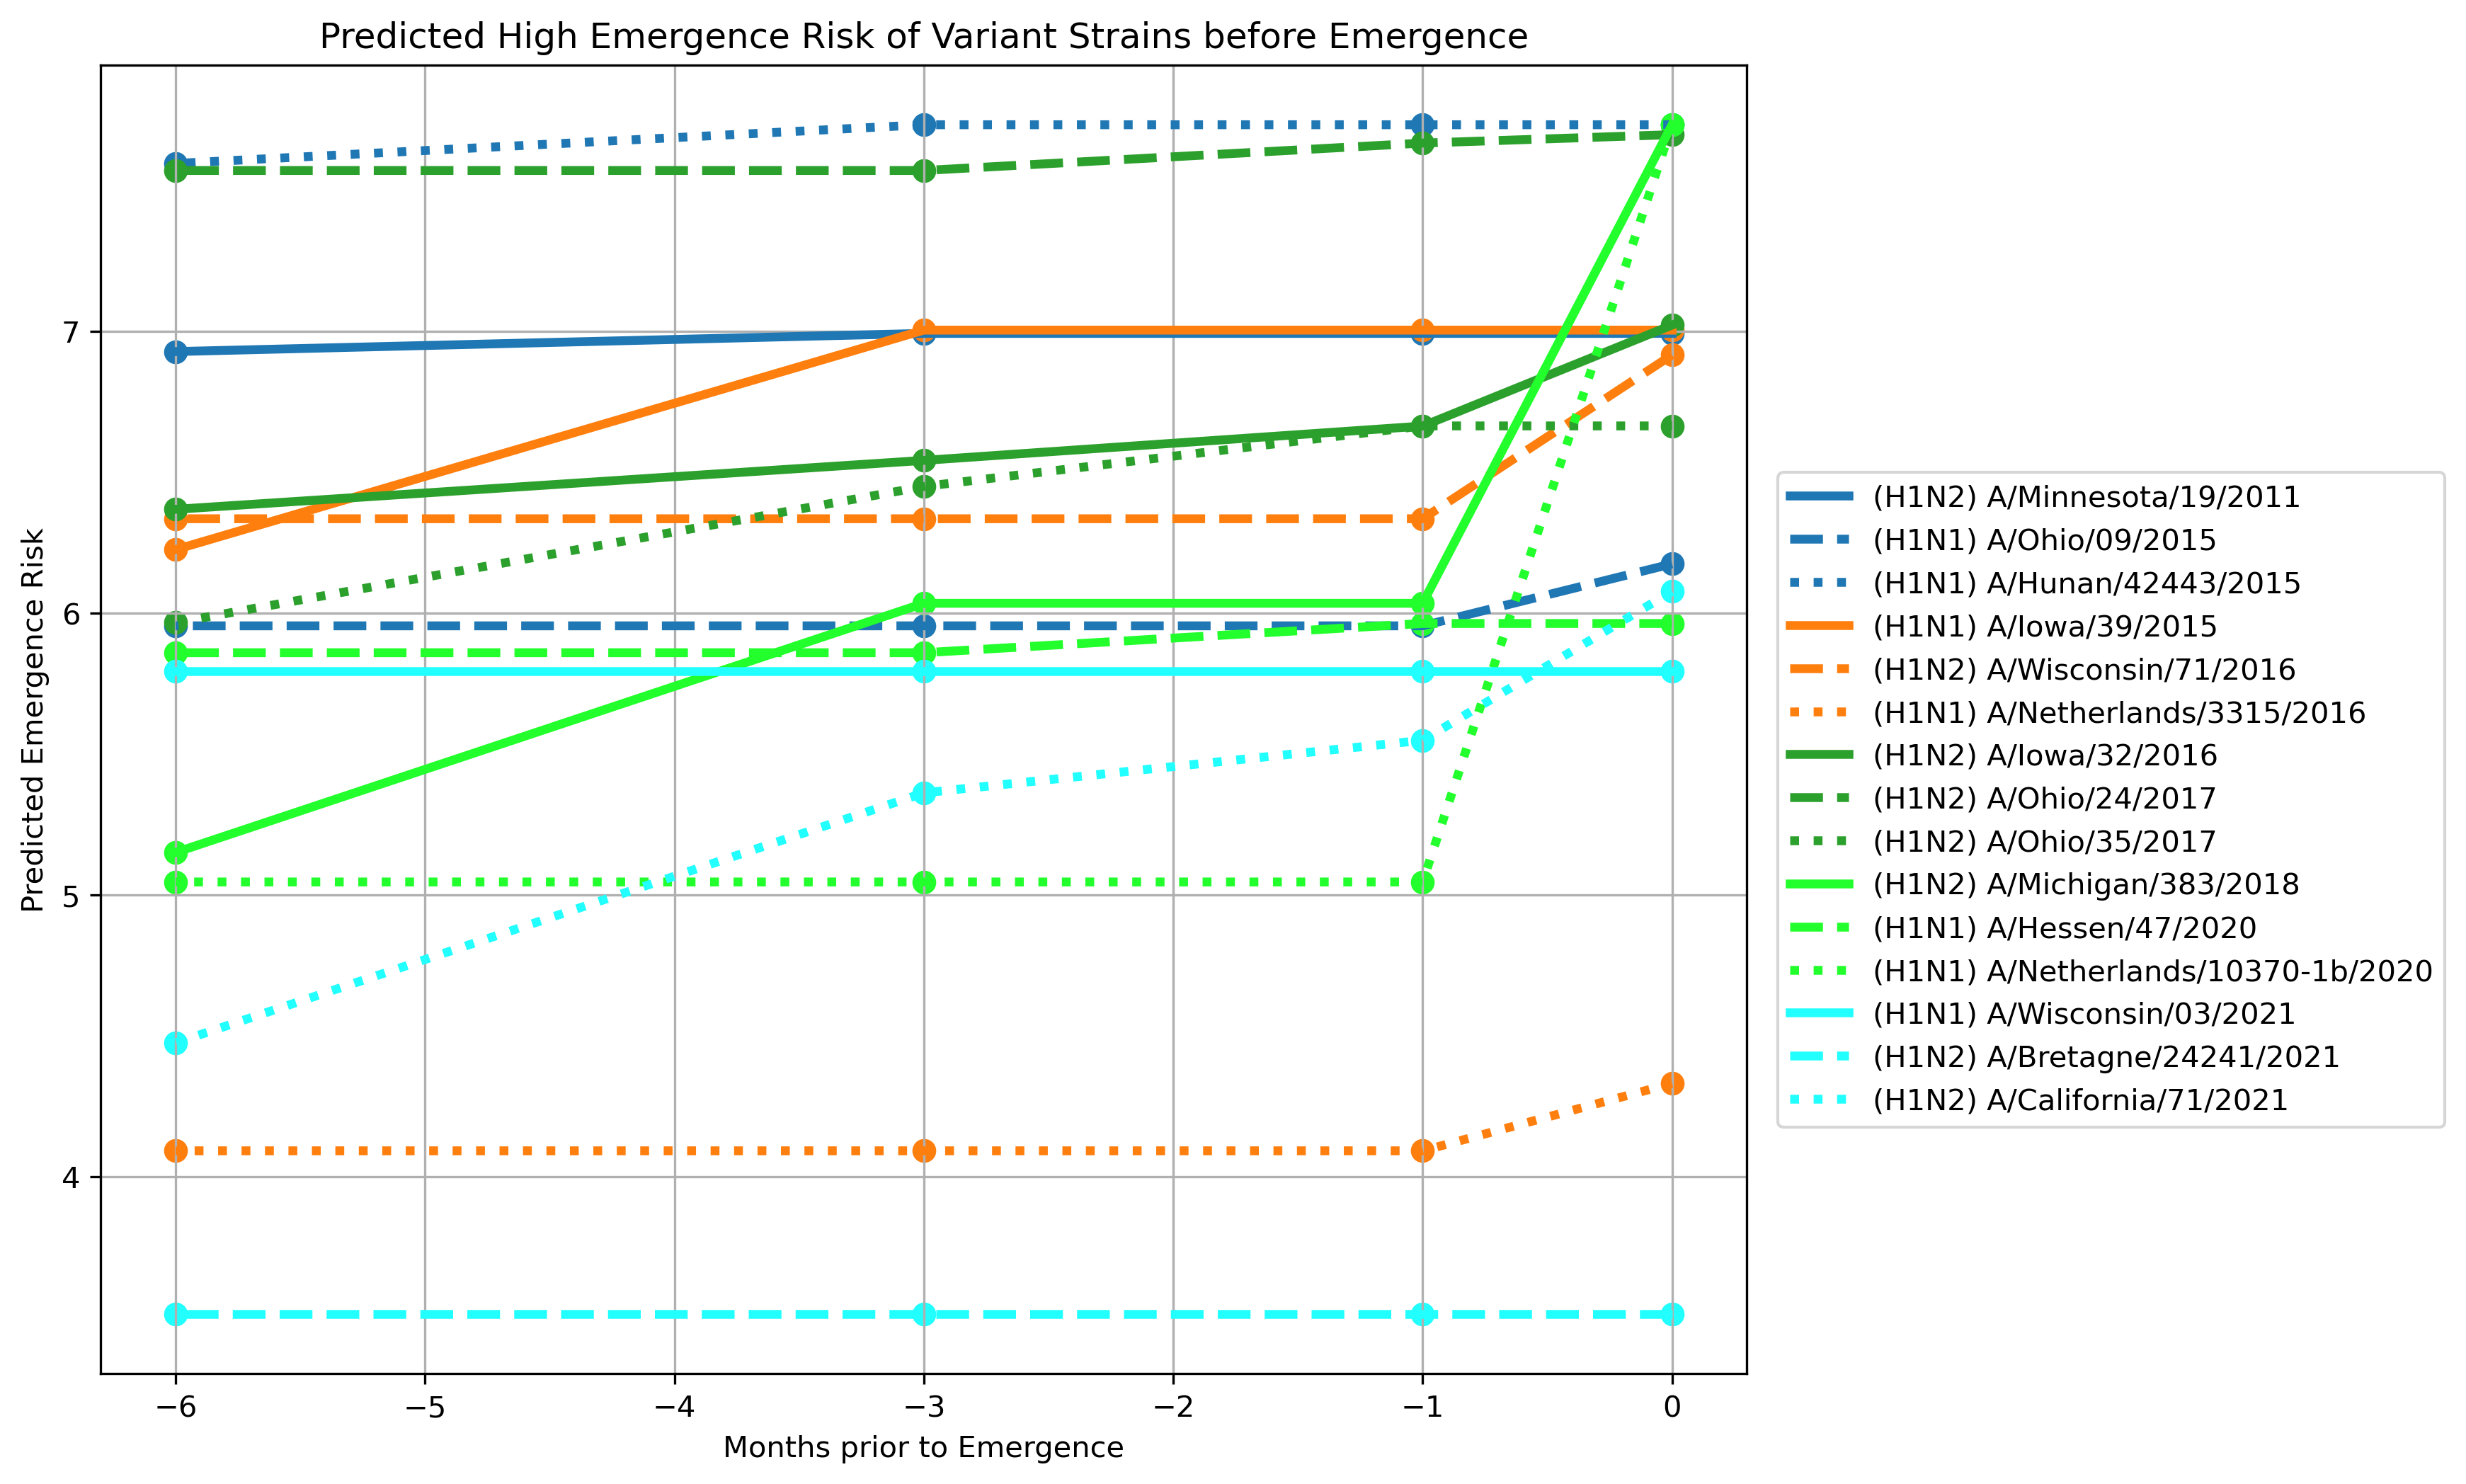

In [67]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#22ff2c', '#22ffff', '#ee22dd', '#336677']
linestyles = ['-', '--', ':']
styles = []
for c in colors:
    for l in linestyles:
        styles.append([c, l])

plt.figure(figsize=(10, 8))
x = [0, -1, -3, -6]
for i, name in enumerate(data.index):
    color = styles[i][0]
    linestyle = styles[i][1]
    plt.scatter(x, data.T[name], color=color, s=50)
    plt.plot(x, data.T[name], label=f'({variant["subtype"].values[i]}) '+name, linewidth=3, linestyle=linestyle, color=color)

plt.title('Predicted High Emergence Risk of Variant Strains before Emergence')
plt.xlabel('Months prior to Emergence')
#plt.ylim((6, 9.3))
plt.ylabel('Predicted Emergence Risk')
plt.legend(bbox_to_anchor=(1.01, 0.7))
plt.grid()
plt.savefig(OUT_DIR + 'variant.png', bbox_inches='tight', transparent=True)
import tikzplotlib
tikzplotlib.save("../../tex/overleaf3/Figures/variant.tex")


<AxesSubplot:xlabel='emergence_0', ylabel='Count'>

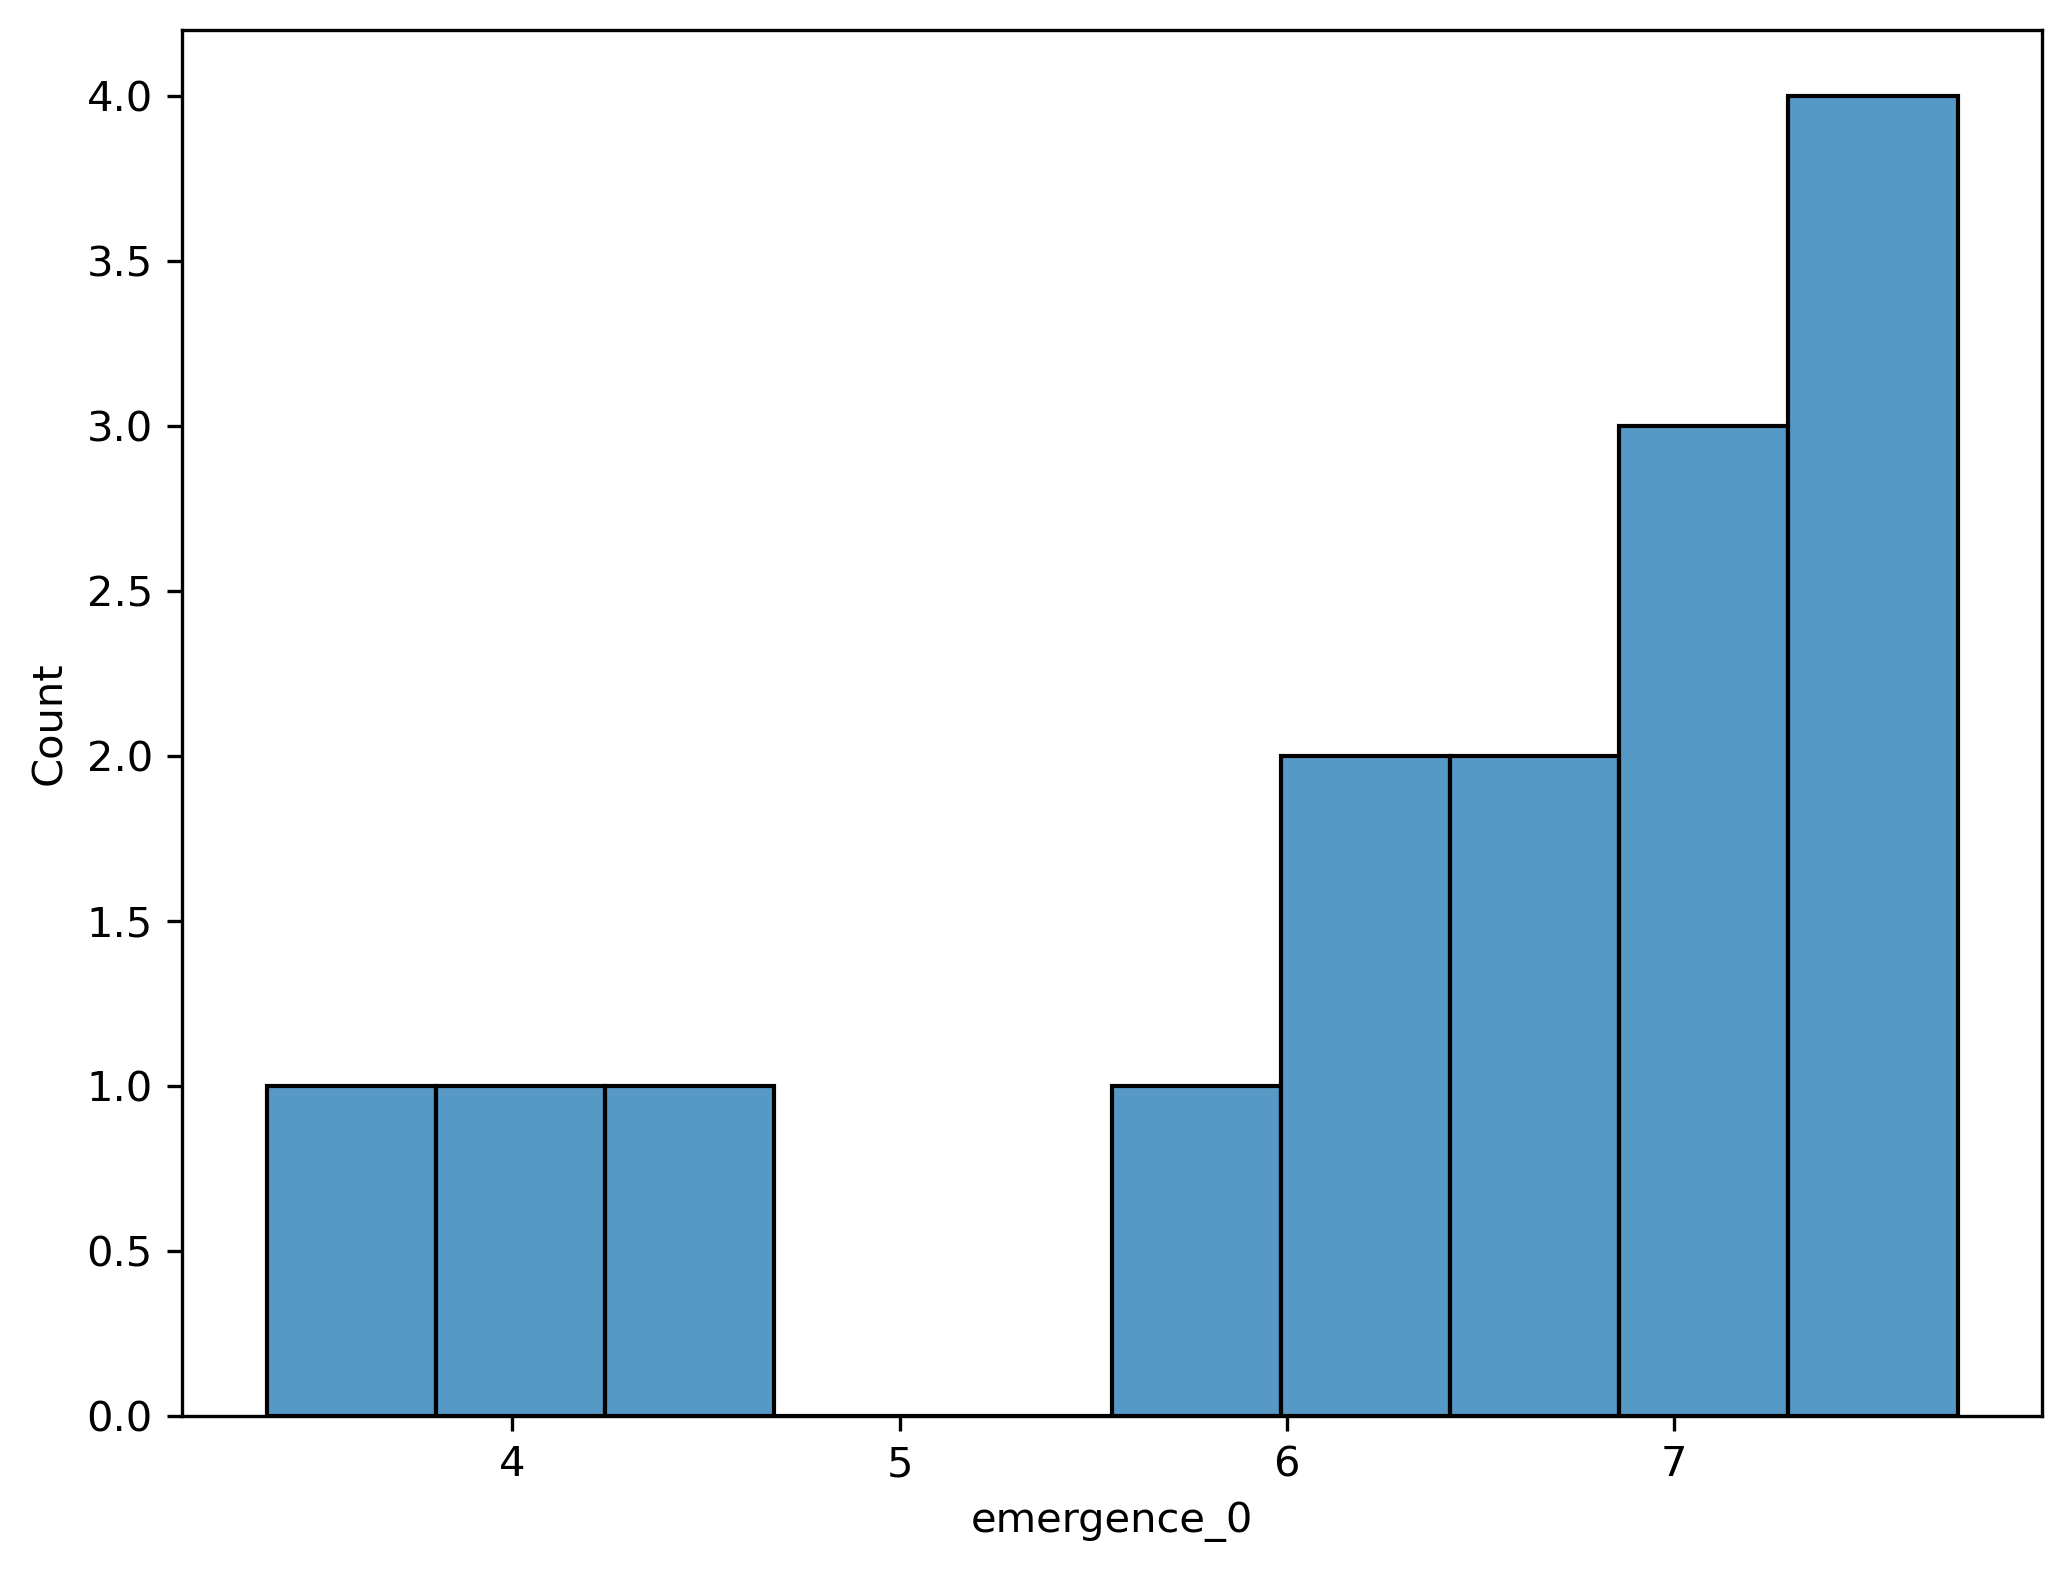

In [68]:
import seaborn as sns
sns.histplot(variant.emergence_0,bins=10)

In [64]:
np.array([np.sum(variant.emergence_0>7), np.sum(variant.emergence_0>6.75), np.sum(variant.emergence_0>6.5)])

array([5, 7, 9])